In [1]:
import os
import sys

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


import ast
import math

import numpy as np


from utils.gcloud_utilities import *

from utils.metadata import *

from utils.preprocessing_utilities import (
    import_operating_nodes,
    expand_parameters_col_and_format,
)

In [2]:
year = "2023"

# Load data
bucket, nodes = import_operating_nodes(year)
endUse_nodes = pull_from_gcs_csv(
    bucket, GCLOUD_PREPROCESSED_DIR + BENCHMARK_PREPROCESSED_DIR + "endUse_nodes.csv"
)

edges = pull_from_gcs_csv(
    bucket,
    GCLOUD_PREPROCESSED_DIR
    + BENCHMARK_PREPROCESSED_DIR
    + BENCHMARK_EDGES_DIR
    + BENCHMARK_EDGES_FILE,
)

edges["properties"] = edges["properties"].astype(str).apply(ast.literal_eval)
dict_df = pd.json_normalize(edges["properties"])
edges = edges.drop(columns=["properties"]).join(dict_df)

nodes_df = pd.concat((nodes, endUse_nodes))

nodes_df["type"] = (
    nodes_df["mine_type"]
    .fillna(nodes_df["process_type"])
    .fillna(nodes_df["product_type"])
)
nodes_df["country"] = nodes_df["country"].fillna(nodes_df["region"])
nodes_df["company"] = nodes_df["company"].fillna(nodes_df["operator_short_clean"])
# nodes_df = nodes_df.dropna(subset=['type'])[['node_id', 'type', year]]

stages_dict = {
    "mining": ["Brine", "Spodumene", "Mica", "Pegmatite"],
    "carbonate": ["Lithium Carbonate"],
    "hydroxide": ["Lithium Hydroxide"],
    "cathode": [
        "NCM mid nickel",
        "LFP",
        "4V Ni or Mn based",
        "NCA",
        "NCM high nickel",
        "LCO",
        "NCM low nickel",
        "5V Mn based",
    ],
    "battery": [
        "Cylindrical",
        "Pouch",
        "Cylindrical, Pouch",
        "Pouch, Prismatic",
        "Prismatic",
        "Cylindrical, Prismatic",
        "Cylindrical, Pouch, Prismatic",
    ],
    "end_use": ["EV", "ESS", "Portable"],
}

nodes_df["stage"] = nodes_df["type"].map(
    {item: cat for cat, items in stages_dict.items() for item in items}
)


# nodes_df = nodes_df.dropna(subset=['stage'])

2025-05-22 11:23:54.286 | INFO     | utils.gcloud_utilities:fetch_gcs_bucket:16 - Fetching GCS bucket: lithium-datasets in project: critical-minerals'
c:\Users\bapti\OneDrive - University of Cambridge\Documents\critical-minerals\.venv\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
2025-05-22 11:23:57.515 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/benchmark_nodes.csv in bucket lithium-datasets
2025-05-22 11:23:59.294 | INFO     | utils.gcloud_utilities:pull_from_gcs_csv:27 - Pulling data from preprocessed/benchmark/endUse_nodes.csv in bucket lithium-datasets
2025-05-22 11:23:59.473

In [3]:
inputs = edges.merge(
    nodes_df[["node_id", "type", "stage", "country", "company"]],
    left_on=["source", "edge_type"],
    right_on=["node_id", "type"],
    how="left",
)
outputs = inputs[
    [
        "stage",
        "type",
        "source",
        "target",
        "2023_volume",
        "edge_type",
        "edge_destination",
        "country",
        "company",
    ]
].merge(
    nodes_df[["node_id", "stage", "type", "country", "company"]],
    left_on="target",
    right_on="node_id",
    how="left",
    suffixes=("_source", "_target"),
)
outputs = outputs[
    (outputs["edge_destination"].isna())
    | (outputs["edge_destination"] == outputs["type_target"])
]

In [4]:
# 2. Keep only rows where stage_target matches next_stage_map[stage_source]
stages = list(stages_dict.keys())
next_stage_map = {stages[i]: stages[i + 1] for i in range(len(stages) - 1)}

real_flows = pd.concat(
    (
        outputs[outputs["stage_source"].map(next_stage_map) == outputs["stage_target"]],
        outputs[
            (outputs["stage_source"] == "mining")
            & (outputs["stage_target"] == "hydroxide")
        ],
        outputs[
            (outputs["stage_source"] == "carbonate")
            & (outputs["stage_target"] == "cathode")
        ],
    )
)

real_flows = real_flows[real_flows["source"] != real_flows["target"]]

cathode_types = stages_dict["cathode"]

# Add node id prefix based on cathode type due to multiple cathode types from some facilities
prefix_values = [str(i) for i in range(10, 56, 5)]  # Define prefix order
prefix_map = dict(zip(cathode_types, prefix_values))  # Create mapping
real_flows["source"] = (
    real_flows["type_source"].map(prefix_map).fillna("")
    + real_flows["source"].astype(str)
).astype(int)

real_flows["target"] = (
    real_flows["type_target"].map(prefix_map).fillna("")
    + real_flows["target"].astype(str)
).astype(int)

In [5]:
import networkx as nx

df = real_flows.copy()

# Choose the final target node
final_target = 1469  # battery manufacture (Envision, UK)
final_target = 1409  # battery manufacture (CATL, Yibin, China)

# Build a directed graph from the DataFrame
G = nx.from_pandas_edgelist(
    df,
    source="source",
    target="target",
    edge_attr=year + "_volume",
    create_using=nx.DiGraph(),
)


def compute_flow_fractions(G, target, vol_attr="vol"):
    """
    Computes the fraction of flow at each node that eventually reaches `target`.
    Assumes the graph is a DAG.
    """
    # Initialize all fractions to zero; set target's fraction to 1.
    fractions = {node: 0 for node in G.nodes()}
    fractions[target] = 1.0

    try:
        # Get a topological ordering (requires a DAG)
        topo_order = list(nx.topological_sort(G))
    except nx.NetworkXUnfeasible:
        raise ValueError("The graph contains cycles. This method assumes a DAG.")

    # Process nodes in reverse topological order (from target upstream)
    topo_order.reverse()
    for node in topo_order:
        # For every predecessor of the current node,
        # add the contribution from the edge from pred -> node.
        for pred in G.predecessors(node):
            # Sum of volumes on all edges leaving 'pred'
            out_edges = list(G.out_edges(pred, data=True))
            total_out = sum(edge_data[vol_attr] for _, _, edge_data in out_edges)
            if total_out > 0:
                # The fraction of pred's flow that goes to this child
                flow_ratio = G[pred][node][vol_attr] / total_out
                fractions[pred] += fractions[node] * flow_ratio
    return fractions


# Compute flow fractions for each node
fractions = compute_flow_fractions(G, final_target, vol_attr=year + "_volume")
print("Flow fractions by node:")
for node, frac in fractions.items():
    print(f"  {node}: {frac:.3f}")

# Now, adjust each edge's volume to only account for the portion that eventually reaches final_target.
# For an edge (i -> j), the adjusted volume is: vol(i->j) * fraction[j]
df["adj_vol"] = df.apply(
    lambda row: row[year + "_volume"] * fractions.get(row["target"], 0), axis=1
)

upstream_tree = df[df["adj_vol"] > 0]

Flow fractions by node:
  369: 0.029
  565: 0.029
  115: 0.032
  639: 0.032
  579: 0.032
  308: 0.032
  223: 0.043
  647: 0.043
  400: 0.043
  561: 0.043
  658: 0.043
  454: 0.025
  625: 0.025
  607: 0.025
  519: 0.025
  339: 0.025
  178: 0.025
  424: 0.043
  652: 0.043
  690: 0.043
  675: 0.043
  327: 0.043
  309: 0.043
  54: 0.043
  543: 0.043
  294: 0.043
  500: 0.043
  645: 0.043
  333: 0.043
  63: 0.067
  680: 0.032
  53: 0.043
  587: 0.043
  371: 0.043
  567: 0.043
  74: 0.043
  629: 0.043
  476: 0.043
  689: 0.043
  128: 0.043
  502: 0.043
  95: 0.043
  331: 0.043
  233: 0.043
  611: 0.043
  532: 0.043
  522: 0.043
  622: 0.043
  691: 0.043
  635: 0.043
  516: 0.043
  70: 0.043
  357: 0.043
  444: 0.043
  262: 0.043
  463: 0.043
  301: 0.043
  283: 0.046
  535: 0.043
  569: 0.043
  505: 0.043
  618: 0.043
  552: 0.043
  529: 0.043
  511: 0.043
  557: 0.043
  654: 0.057
  521: 0.043
  632: 0.118
  667: 0.043
  592: 0.043
  666: 0.043
  247: 0.046
  405: 0.043
  471: 0.039
  27: 0

In [ ]:
unit_conversion = pull_from_gcs_excel(
    bucket, MAPPINGS_DIR + "Li_unit_conversion.xlsx", sheet_name="Sheet1"
)


converted_df = df.merge(
    unit_conversion[["type", "edge_conversion"]],
    left_on="type_source",
    right_on="type",
    how="left",
)

converted_df["adj_vol_lithium"] = (
    converted_df["adj_vol"] * converted_df["edge_conversion"]
)

2025-05-22 11:24:20.245 | INFO     | utils.gcloud_utilities:pull_from_gcs_excel:46 - Pulling data from raw/mappings/Li_unit_conversion.xlsx in bucket lithium-datasets


In [7]:
converted_tree = upstream_tree.merge(
    unit_conversion[["type", "edge_conversion"]],
    left_on="type_source",
    right_on="type",
    how="left",
)
converted_tree["adj_vol_lithium"] = (
    converted_tree["adj_vol"] * converted_tree["edge_conversion"]
)

converted_tree["stage_source"] = converted_tree["stage_source"].str.capitalize()
converted_tree = converted_tree.rename(
    columns={
        "source": "Node ID",
        "country_source": "Country",
        "stage_source": "Supply stage",
        "type_source": "Type",
        "edge_type": "Product",
        "adj_vol": "Product mass (t)",
        "adj_vol_lithium": "Lithium equivalent (t)",
    }
)

In [ ]:
# Output key nodes
node_proportions = (
    converted_tree.groupby(
        ["Supply stage", "Type", "Node ID", "Country", "company_source", "Product"]
    )
    .sum()
    .sort_values("Lithium equivalent (t)", ascending=False)
    .reset_index()[
        [
            "Node ID",
            "Country",
            "Supply stage",
            "Product",
            "Product mass (t)",
            "Lithium equivalent (t)",
        ]
    ]
)

top10_nodes = node_proportions.rename(
    columns={
        "Node ID": "Source ID",
        "Country": "Source",
        "target": "Target ID",
        "country_target": "Target",
    }
).head(10)

# Work out percentages
total_per_prod = node_proportions.groupby("Product").sum()[["Product mass (t)"]]
total_per_stage = node_proportions.groupby("Supply stage").sum()[
    ["Lithium equivalent (t)"]
]

top10_nodes_perc = top10_nodes.merge(
    total_per_prod, on="Product", suffixes=("", "_total")
)
top10_nodes_perc["Product mass (%)"] = (
    top10_nodes_perc["Product mass (t)"]
    / top10_nodes_perc["Product mass (t)_total"]
    * 100
)
top10_nodes_perc = top10_nodes_perc.drop(columns="Product mass (t)_total")

top10_nodes_perc["Lithium equivalent (%)"] = total_per_stage.loc[
    "Cathode", "Lithium equivalent (t)"
]
top10_nodes_perc["Lithium equivalent (%)"] = (
    top10_nodes_perc["Lithium equivalent (t)"]
    / top10_nodes_perc["Lithium equivalent (%)"]
    * 100
)

# Convert the DataFrame to LaTeX table format
latex_nodes = top10_nodes_perc[
    [
        "Source ID",
        "Source",
        "Supply stage",
        "Product",
        "Product mass (t)",
        "Product mass (%)",
        "Lithium equivalent (t)",
        "Lithium equivalent (%)",
    ]
].to_latex(float_format=lambda x: f"{x:,.0f}", index=False)

output_path = "/figures/main_results/"
filename = "nodes_table_"

# Save the LaTeX table to a text file
with open(
    #  "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/outputs/nodes_table_"
    project_root + output_path + filename + str(final_target) + ".tex",
    "w",
) as file:
    file.write(latex_nodes)

In [ ]:
# Output key flows
edge_proportions = converted_tree.sort_values(
    "Lithium equivalent (t)", ascending=False
)[
    [
        "Node ID",
        "Country",
        "target",
        "country_target",
        "Product",
        "Product mass (t)",
        "Lithium equivalent (t)",
    ]
]

top10_edges = edge_proportions.rename(
    columns={
        "Node ID": "Source ID",
        "Country": "Source",
        "target": "Target ID",
        "country_target": "Target",
    }
).head(10)

# Work out percentages
total_per_prod = edge_proportions.groupby("Product").sum()[["Product mass (t)"]]

top10_edges_perc = top10_edges.merge(
    total_per_prod, on="Product", suffixes=("", "_total")
)
top10_edges_perc["Product mass (%)"] = (
    top10_edges_perc["Product mass (t)"]
    / top10_edges_perc["Product mass (t)_total"]
    * 100
)
top10_edges_perc = top10_edges_perc.drop(columns="Product mass (t)_total")

top10_edges_perc["Lithium equivalent (%)"] = total_per_stage.loc[
    "Cathode", "Lithium equivalent (t)"
]
top10_edges_perc["Lithium equivalent (%)"] = (
    top10_edges_perc["Lithium equivalent (t)"]
    / top10_edges_perc["Lithium equivalent (%)"]
    * 100
)

# Convert the DataFrame to LaTeX table format
latex_edges = top10_edges_perc[
    [
        "Source ID",
        "Source",
        "Target ID",
        "Target",
        "Product",
        "Product mass (t)",
        "Product mass (%)",
        "Lithium equivalent (t)",
        "Lithium equivalent (%)",
    ]
].to_latex(float_format=lambda x: f"{x:,.0f}", index=False)

filename = "edges_table_"
# Save the LaTeX table to a text file
with open(
    project_root + output_path + filename + str(final_target) + ".tex",
    "w",
) as file:
    file.write(latex_edges)

In [13]:
volumes = upstream_tree.groupby(
    ["stage_source", "type_source", "stage_target", "type_target", "country_source"]
).sum()["adj_vol"]

companies = (
    upstream_tree.groupby(["stage_source", "type_source"])["company_source"]
    .nunique()
    .reset_index()
)

output_flows = volumes.reset_index().merge(
    companies, on=["stage_source", "type_source"], how="left"
)

output_flows = output_flows.merge(
    companies.rename(
        columns={"stage_source": "stage_target", "type_source": "type_target"}
    ),
    on=["stage_target", "type_target"],
    how="left",
)

output_flows["company_source_y"] = (
    output_flows["company_source_y"].fillna(1).astype(int)
)

In [15]:
# unit_conversion = pd.read_excel(
#     "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/data/Mappings/Li_unit_conversion.xlsx"
# )

unit_conversion = pull_from_gcs_excel(
    bucket, MAPPINGS_DIR + "Li_unit_conversion.xlsx", sheet_name="Sheet1"
)

converted_edges = output_flows.merge(
    unit_conversion[["type", "edge_conversion"]],
    left_on="type_source",
    right_on="type",
    how="left",
)
converted_edges["adj_vol"] = (
    converted_edges["adj_vol"] * converted_edges["edge_conversion"]
)
# converted_edges = converted_edges[converted_edges['adj_vol'] > 0.001]

2025-05-22 11:27:22.518 | INFO     | utils.gcloud_utilities:pull_from_gcs_excel:46 - Pulling data from raw/mappings/Li_unit_conversion.xlsx in bucket lithium-datasets


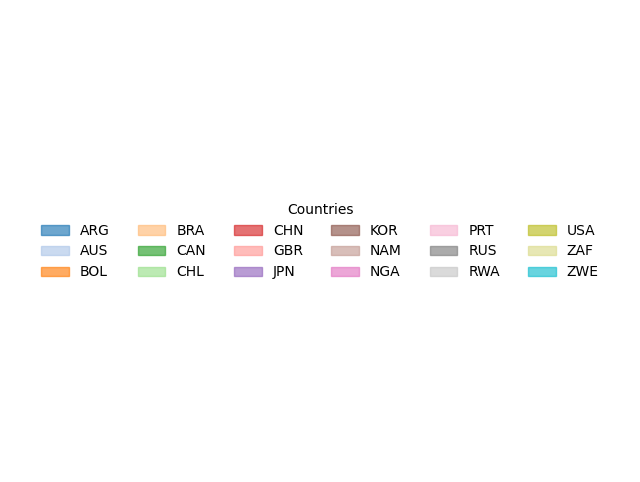

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Sort the unique countries for consistency
unique_countries = sorted(converted_edges["country_source"].unique())

# Use the 'tab20' colormap which provides 20 distinct, professional colors
cmap = plt.get_cmap("tab20")

# Create a mapping from each country to a hex color
color_mapping = {
    country: mcolors.rgb2hex(cmap(i / len(unique_countries)))
    for i, country in enumerate(unique_countries)
}

# Create a list of patches for the legend using the color mapping
handles = [
    mpatches.Patch(color=color, label=country, alpha=0.65)
    for country, color in color_mapping.items()
]

# Create a new figure solely for the legend
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")  # Hide the axes

# Add the legend to the figure, arranged horizontally in 6 columns
legend = ax.legend(
    handles=handles, loc="center", frameon=False, title="Countries", ncol=6
)

output_path = "/figures/article_figures/"
filename = "tree_legend_"

# Save the figure as a PDF
fig.savefig(
    #  "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Research_papers/CCG/P3c_lithium_supply_chains/figures/tree_legend_"
    project_root + output_path + filename + str(final_target) + ".pdf",
    bbox_inches="tight",
)

plt.show()  # Optionally display the figure

# Map the colors back to your data
converted_edges["color_hex"] = converted_edges["country_source"].map(color_mapping)

In [18]:
import json

# Saving the dictionary to a file in JSON format
with open("color_map_temp.json", "w") as json_file:
    json.dump(color_mapping, json_file)

In [19]:
# Significant figure function
def round_to_n_sf(x, n):
    if x == 0:
        return 0
    order = math.floor(math.log10(abs(x)))
    # Calculate the number of decimal places needed for n significant figures
    return round(x, n - 1 - order)

In [20]:
# Balance with total outputs
# totals = converted_edges.groupby('type').sum()['adj_vol'].reset_index()
inflows = (
    converted_edges.groupby(["stage_source", "type_source"])
    .sum()["adj_vol"]
    .reset_index()
)
outflows = (
    converted_edges.groupby(["stage_target", "type_target"])
    .sum()["adj_vol"]
    .reset_index()
)

losses = inflows.merge(outflows, left_on="type_source", right_on="type_target")
losses["adj_vol"] = losses["adj_vol_y"] - losses["adj_vol_x"]
losses["stage_target"] = losses["stage_source"]
losses["type_target"] = [
    i.capitalize() + "\nLosses\n& Stock" for i in losses["stage_source"]
]
losses["company_source_x"] = losses["type_source"].map(
    dict(zip(converted_edges["type_source"], converted_edges["company_source_x"]))
)
losses["company_source_y"] = 0
losses["edge_type"] = losses["type_source"]
losses["color_hex"] = "#0a0a0a"

from_stocks = inflows.merge(outflows, left_on="type_source", right_on="type_target")
from_stocks["adj_vol"] = from_stocks["adj_vol_x"] - from_stocks["adj_vol_y"]
from_stocks["stage_source"] = from_stocks["stage_target"]
from_stocks["type_source"] = [
    i.capitalize() + " Stock" for i in from_stocks["stage_target"]
]
from_stocks["company_source_y"] = from_stocks["type_target"].map(
    dict(zip(converted_edges["type_target"], converted_edges["company_source_y"]))
)
from_stocks["company_source_x"] = 0
from_stocks["edge_type"] = from_stocks["type_target"]
from_stocks["color_hex"] = "#0a0a0a"

from_stocks["adj_vol"] = np.where(from_stocks["adj_vol"] < 0, 0, from_stocks["adj_vol"])
losses["adj_vol"] = np.where(losses["adj_vol"] < 0, 0, losses["adj_vol"])

converted_edges = pd.concat((converted_edges, losses, from_stocks))
converted_edges = converted_edges.drop(columns=["adj_vol_x", "adj_vol_y"])
converted_edges = converted_edges[converted_edges["adj_vol"] > 0.01]

In [ ]:
converted_edges["adj_vol"] = converted_edges["adj_vol"].apply(
    lambda x: round_to_n_sf(x, 2)
)
converted_edges["SankeyMatic"] = converted_edges.apply(
    lambda row: (
        f"{row['type_source']}\\n({row['company_source_x']}) [{row['adj_vol']}] {row['type_target']}\\n({row['company_source_y']}) {row['color_hex']}"
        if row["company_source_y"] > 0 and row["company_source_x"] > 0
        else (
            f"{row['type_source']}\\n({row['company_source_x']}) [{row['adj_vol']}] {row['type_target']} {row['color_hex']}"
            if row["company_source_x"] > 0
            else f"{row['type_source']} [{row['adj_vol']}] {row['type_target']}\\n({row['company_source_y']}) {row['color_hex']}"
        )
    ),
    axis=1,
).str.replace(", ", "/")

output_path = "/figures/main_results/"
filename = "P3c_tree"


converted_edges["SankeyMatic"].to_csv(
    # "/Users/lukecullen/Library/CloudStorage/OneDrive-UniversityofCambridge/Post-doc/P3c/outputs/P3c_tree"
    project_root + output_path + filename + str(final_target) + ".txt",
    index=False,
    header=False,
)

In [23]:
china = converted_edges.copy()

In [24]:
uk = converted_edges.copy()

In [25]:
china_filt = china[["Stock" not in i for i in china["type_target"]]]
china_filt = china_filt[["Stock" not in i for i in china_filt["type_source"]]]

In [26]:
china_tots = china_filt[["stage_source", "adj_vol"]].groupby(["stage_source"]).sum()

In [27]:
china_tots

,adj_vol
stage_source,
carbonate,4209.083
cathode,9337.000
hydroxide,6882.100
mining,9602.720


In [28]:
china_own = china_filt[china_filt["country_source"] == "CHN"]

In [29]:
china_own_tot = china_own[["stage_source", "adj_vol"]].groupby(["stage_source"]).sum()

In [30]:
china_own_tot / china_tots

,adj_vol
stage_source,
carbonate,0.648122
cathode,0.951698
hydroxide,0.988071
mining,0.128089
